# Web scraping + Sentiment Analysis + DL

## Parámetros

In [1]:
from pathlib import Path

BASE_DIR = Path('/Users/efraflores/Desktop/hub/datathon2021/datathon2021/data/test')
FILE_NAME = 'OnlineNewsPopularity.csv'

## Entorno

In [2]:
# Data Wrangling
import numpy as np
import pandas as pd
from functools import reduce

# Web scraping
import requests
from bs4 import BeautifulSoup
from multiprocessing import Pool

# Data cleaning
import re
import unicodedata

# Data visualization
from IPython.display import Image
from tensorflow.keras.utils import plot_model

# Data modeling
from tensorflow.keras import Model
from tensorflow.keras.layers import GRU, Input, Dense, Embedding, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Text mining
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Model performance
from tensorflow.keras import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Funciones

### Outliers

In [3]:
from sklearn.ensemble import IsolationForest

def outliers(df,cols):
    outlier = IsolationForest(contamination=.04,n_jobs=-1)
    df['outlier'] = outlier.fit_predict(df[cols])
    df = df[df['outlier']!=-1].drop(columns = 'outlier')
    return df

### Scrape

In [4]:
def scrape(url):
    req = requests.get(url)
    return url, req.text

### Make pool

In [5]:
def make_pool(func, params, threads):
    pool = Pool(threads)
    data = pool.map(func, params)
    pool.close()
    pool.join()
    del pool
    return data

### Get data

In [6]:
def get_data(soup):
    title = soup.find_all("h1")[0].text if len(soup.find_all("h1")) > 0 else ''
    subtitles = soup.find_all("h2")
    channel = subtitles[0].text if len(subtitles) > 0 else ''
    images = len(soup.find_all("img"))
    videos = len(soup.find_all("iframe"))
    paragraphs = soup.find_all("article")
    text = "\n".join([x.text for x in paragraphs])
    return title, len(subtitles), channel, images, videos, len(paragraphs), text

### Sentiment

In [7]:
sid = SentimentIntensityAnalyzer()

def sentiment(text):
    sentences = sent_tokenize(text)
    polarities = list(map(sid.polarity_scores, sentences))
    return polarities[0]

sentiment('I am very happy!!!')

{'neg': 0.0, 'neu': 0.304, 'pos': 0.696, 'compound': 0.6785}

### Text features

In [8]:
def text_features(url, text):
    sentences = sent_tokenize(text)
    words = pd.DataFrame(map(len, map(word_tokenize, sentences)), columns=['n_words'])
    words["url"] = url
    return words

text_features('','I am very happy!')

,n_words,url
0,5,


### Clean text

In [9]:
import re
import unicodedata
from emoji import demojize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

def clean_text(text, language='english', pattern="[^a-zA-Z\s]", add_stopw=[],
                lower=False, lemma=False, rem_stopw=False, unique=False, emoji=False):
    if emoji: text = demojize(text)
    cleaned_text = unicodedata.normalize('NFD',str(text).replace('\n',' \n ')).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern,' ',cleaned_text.decode('utf-8'),flags=re.UNICODE)
    cleaned_text = [(lem.lemmatize(word,pos='v') if lemma else word) for word in 
                    (cleaned_text.lower().split() if lower else cleaned_text.split())]
    if rem_stopw: cleaned_text = [word for word in cleaned_text if word not in 
                                  stopwords.words(language)+add_stopw]
    return ' '.join((set(cleaned_text) if unique else cleaned_text))

#Ex
ex = "I am going to run!!! I ran while I was running??? ..."
print('\nOriginal:\t\t',ex)
print('Basic cleaning:\t\t',clean_text(ex))
print('Changing the pattern:\t',clean_text(ex,pattern="[^a-zA-Z!\.]"))
print('Without stopwords:\t',clean_text(ex,rem_stopw=True))
print('Lower and lemma:\t',clean_text(ex,lower=True,lemma=True))
print('Super cleaning:\t\t',clean_text(ex,add_stopw=['go'],lower=True,rem_stopw=True,lemma=True,unique=True))
print("\nIt actually corrects the weird accents, example\n\tFROM:\t ThÈ ÉfrâïsMã's?...\n\tTO:\t",clean_text("ThÈ ÉfrâïsMa's?...",lower=True))
print("\nAnd now, it can translate emojis!!! 😍",clean_text('😍', emoji=True))


Original:		 I am going to run!!! I ran while I was running??? ...
Basic cleaning:		 I am going to run I ran while I was running
Changing the pattern:	 I am going to run!!! I ran while I was running ...
Without stopwords:	 I going run I ran I running
Lower and lemma:	 i be go to run i run while i be run
Super cleaning:		 run

It actually corrects the weird accents, example
	FROM:	 ThÈ ÉfrâïsMã's?...
	TO:	 the efraisma s

And now, it can translate emojis!!! 😍 smiling face with heart eyes


### Vectorize text

In [10]:
def vectorize_text(text, max_words, max_sequence_length):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(text)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, maxlen=max_sequence_length)
    return X, tokenizer

## Dataset original

### Lectura de datos

In [11]:
shares = pd.read_csv(BASE_DIR.joinpath(FILE_NAME))
shares.columns = [x.strip() for x in shares.columns]
shares.sample()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
16884,http://mashable.com/2013/12/02/fighting-conten...,402.0,10.0,312.0,0.596552,1.0,0.722222,11.0,9.0,1.0,...,0.136364,1.0,-0.4,-0.4,-0.4,0.0,0.0,0.5,0.0,1400


### Outliers

<AxesSubplot:>

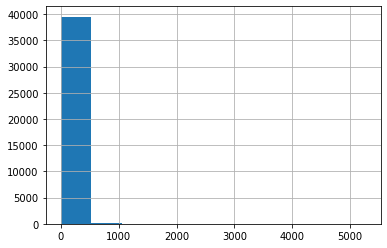

In [12]:
shares["shares"] /= shares["timedelta"]
shares["shares"].hist()

<AxesSubplot:>

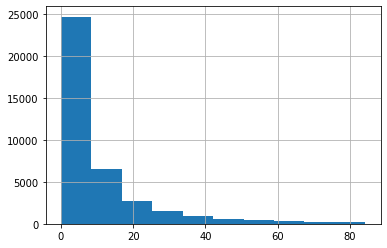

In [13]:
shares = outliers(shares, ['shares'])
shares["shares"].hist()

## Transformar

### Obtención de URLs

In [14]:
aux = shares.sample(100, random_state=777).copy()
aux.sample()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
23147,http://mashable.com/2014/04/08/discovery-inves...,275.0,13.0,785.0,0.413972,1.0,0.56129,7.0,3.0,2.0,...,0.0625,0.7,-0.217157,-0.8,-0.05,0.4,-0.3,0.1,0.3,4.0


### Pool Function

In [15]:
# Import from a .py file to make Pool work
from PoolFunctions import scrape as py_scrape

scrapped = [(url, BeautifulSoup(text)) for url, text in make_pool(func=py_scrape, params=aux["url"].tolist(), threads=32)]
str(scrapped[0][1])[:222]

'<!DOCTYPE html>\n\n<html lang="en">\n<head>\n<title>\'The Hobbit: The Desolation of Smaug\' Trailer Is Finally Here</title>\n<meta charset="utf-8"/>\n<link href="https://mashable.com/archive/hobbit-desolation-smaug-trailer" rel="c'

In [16]:
text_data = [(url, get_data(soup)) for url, soup in scrapped]
df = pd.DataFrame([{"url": url, "title": features[0], "n_headers": features[1], "channel": features[2], "n_images": features[3], "n_videos": features[4], "n_paragraphs": features[5], "text": features[6]} for url, features in text_data])
df.sample()

,url,title,n_headers,channel,n_images,n_videos,n_paragraphs,text
47,http://mashable.com/2014/05/09/pussy-riot-occu...,Pussy Riot Visits NYC Jail to Support Occupy W...,0,,5,1,1,"\nRIKERS ISLAND, New York -- Two members of th..."


In [17]:
print(df.loc[0, "text"])


"Was that an earthquake?" asks a terrified dwarf in the first teaser trailer for The Hobbit: The Desolation of Smaug, this winter's follow-up to 2012's An Unexpected Journey in the three-part film adaptation of the The Hobbit novel.
"That, my lad, was a dragon," elder dwarf Balin responds perilously.
SEE ALSO: Real Google Interns Say 'The Internship' Movie Kind of Nails It
And not just any dragon. It's Smaug, a destructive fire-breathing legend of Middle-earth. Smaug calls Lonely Mountain home, where a treasure trove of gold awaits anyone who dares overtake his fiery guard. Therein lies the gist of trailer from Warner Bros.
"If you awaken that beast, you will destroy us all," one warns a brave-faced Thorin.
Well, then. Good luck to all, particularly Bilbo Baggins, Gandalf and the 13 dwarves as they continue their journey to reclaim dwarf kingdom Erebor.
What do you think of the first glimpse of the new Hobbit flick, which arrives in theaters Dec. 13? Watch the trailer above, then let 

### Pool Sentiment

In [18]:
# Import from a .py file to make Pool work
from PoolFunctions import sentiment as py_sentiment

for cont in ['title','text']:
    df[f'{cont}_sentim'] = [x for x in make_pool(func=py_sentiment, params=df[cont], threads=32)]
    sentim = pd.DataFrame(df[f'{cont}_sentim'].tolist(), index=df.index)
    sentim.columns = [f'{x}_{cont}' for x in sentim.columns]
    df = df.join(sentim).drop(columns=[f'{cont}_sentim'])

df.sample()

,url,title,n_headers,channel,n_images,n_videos,n_paragraphs,text,neg_title,neu_title,pos_title,compound_title,neg_text,neu_text,pos_text,compound_text
28,http://mashable.com/2014/06/14/5-cant-miss-app...,5 Can't-Miss Apps: 'Angry Birds Epic' and More,0,,1,1,1,\nBetween Facebook accidentally unveiling Slin...,0.0,0.689,0.311,0.4023,0.131,0.712,0.157,0.4019


## Modelo supervisado

### EDA

In [19]:
shares = shares[["url", "shares"]]

### Text features

In [20]:
df["urls"] = df["text"].str.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.#&+])+')
df["n_urls"] = df["urls"].str.len()
df["text_cleaned"] = df.apply(lambda row: reduce(lambda string, url: string.replace(url, ""), row["urls"], row["text"]), axis = 1)
df["len_title"] = df["title"].str.len()
df["n_words_title"] = df["title"].str.split(" ").str.len()
df["avg_len_words_title"] = df["title"].str.split(" ").map(lambda x:np.mean([x for x in map(len, x)]))
df["len_content"] = df["text"].str.len()
df["n_words_content"] = df["text"].str.split(" ").str.len()
df["avg_len_words_content"] = df["text"].str.split(" ").map(lambda x:np.mean([x for x in map(len, x)]))
df.sample()

,url,title,n_headers,channel,n_images,n_videos,n_paragraphs,text,neg_title,neu_title,...,compound_text,urls,n_urls,text_cleaned,len_title,n_words_title,avg_len_words_title,len_content,n_words_content,avg_len_words_content
51,http://mashable.com/2013/01/17/twitter-expands...,"Twitter Adds Adobe Social, Visible Technologie...",0,,1,1,1,\nTwitter has added nine new partners to its C...,0.0,1.0,...,0.0,[],0,\nTwitter has added nine new partners to its C...,59,8,6.5,889,124,6.177419


### Clean text

In [21]:
stop_words = stopwords.words("english") + ["url", "seealso", "mashable", "http", "ha", "hi", "will", "new", "one"]
stop_words = [clean_text(word) for word in stop_words]
df["text_cleaned"] = df["text_cleaned"].map(clean_text).map(lambda text: [word for word in text.split() if word not in stop_words]).str.join(" ")
df["title_cleaned"] = df["title"].str.replace("\n", " ").map(clean_text).map(lambda text: [word for word in text.split() if word not in stop_words]).str.join(" ")
df = df.merge(shares, on ="url")
df.sample()

,url,title,n_headers,channel,n_images,n_videos,n_paragraphs,text,neg_title,neu_title,...,n_urls,text_cleaned,len_title,n_words_title,avg_len_words_title,len_content,n_words_content,avg_len_words_content,title_cleaned,shares
2,http://mashable.com/2013/11/05/nfl-mascot-apol...,NFL Mascot Apologizes for Insensitive Tweet Ab...,0,,1,1,1,\nWe live in quite a world.\nWe live in a worl...,0.46,0.36,...,1,We live quite world We live world thanks Twitt...,57,8,6.25,1651,253,5.529644,NFL Mascot Apologizes Insensitive Tweet About ...,2.564103


In [22]:
df.shape

(100, 27)

### Modelado

#### Input 1: Título

In [23]:
X_title = df["title_cleaned"]
X_title.str.split().str.len().max()

13

In [24]:
title_max_words = 5000
title_max_sequence_length = 12
X_title, tokenizer_title = vectorize_text(X_title, title_max_words, title_max_sequence_length)

Found 606 unique tokens.


#### Input 2: Contenido

In [25]:
X_content = df["text_cleaned"]
X_content.str.split().str.len().max()

1793

In [26]:
content_max_words = 10000
content_max_sequence_length = 250
X_content, tokenizer_content = vectorize_text(X_content, content_max_words, content_max_sequence_length)

Found 6617 unique tokens.


#### Input 3: Características numéricas

In [27]:
df.columns

Index(['url', 'title', 'n_headers', 'channel', 'n_images', 'n_videos',
       'n_paragraphs', 'text', 'neg_title', 'neu_title', 'pos_title',
       'compound_title', 'neg_text', 'neu_text', 'pos_text', 'compound_text',
       'urls', 'n_urls', 'text_cleaned', 'len_title', 'n_words_title',
       'avg_len_words_title', 'len_content', 'n_words_content',
       'avg_len_words_content', 'title_cleaned', 'shares'],
      dtype='object')

In [28]:
ls_features = ['n_images',
               'n_videos',
               'compound_title',
               'compound_text',
               'n_urls',
               'len_title',
               'avg_len_words_title',
               'len_content',
               'avg_len_words_content']

X_features = df[ls_features]
X_features.sample()

,n_images,n_videos,compound_title,compound_text,n_urls,len_title,avg_len_words_title,len_content,avg_len_words_content
36,1,1,0.3818,0.431,0,57,5.444444,1729,5.383764


In [29]:
pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())])
X_features = pipe.fit_transform(X_features)
X_features[0]

array([0.        , 0.        , 0.49395123, 0.48743025, 0.        ,
       0.63793103, 0.51943463, 0.05277889, 0.41225542])

In [30]:
X_title.shape, X_content.shape, X_features.shape

((100, 12), (100, 250), (100, 9))

#### Variable objetivo

In [31]:
y = df[["shares"]]
sc = MinMaxScaler()
y = sc.fit_transform(y).ravel()

### Arquitectura 

In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Título
title_input = Input(shape=(None,), name="title")
title_embedding = Embedding(title_max_words, 64)(title_input)
title_features = GRU(32)(title_embedding)

# Contenido
content_input = Input(shape=(None,), name="content")
content_embedding = Embedding(content_max_words, 128)(content_input)
content_features = GRU(64)(content_embedding)

# Numérico
features_input = Input(shape=(X_features.shape[1],), name="features")
features_network = Dense(64, activation="tanh")(features_input)

# Unir tres input
x = concatenate([title_features, content_features, features_network])

# Capa densa
x = Dense(100, activation="sigmoid")(x)

# Capa de salida
pred = Dense(1, activation="linear")(x)

#### Métricas de performance

In [33]:
kmetrics = [
    metrics.RootMeanSquaredError(name='rms'),
    metrics.MeanAbsoluteError(name='mae'),
    metrics.MeanAbsolutePercentageError(name="pema")
]   

#### Creación de modelo

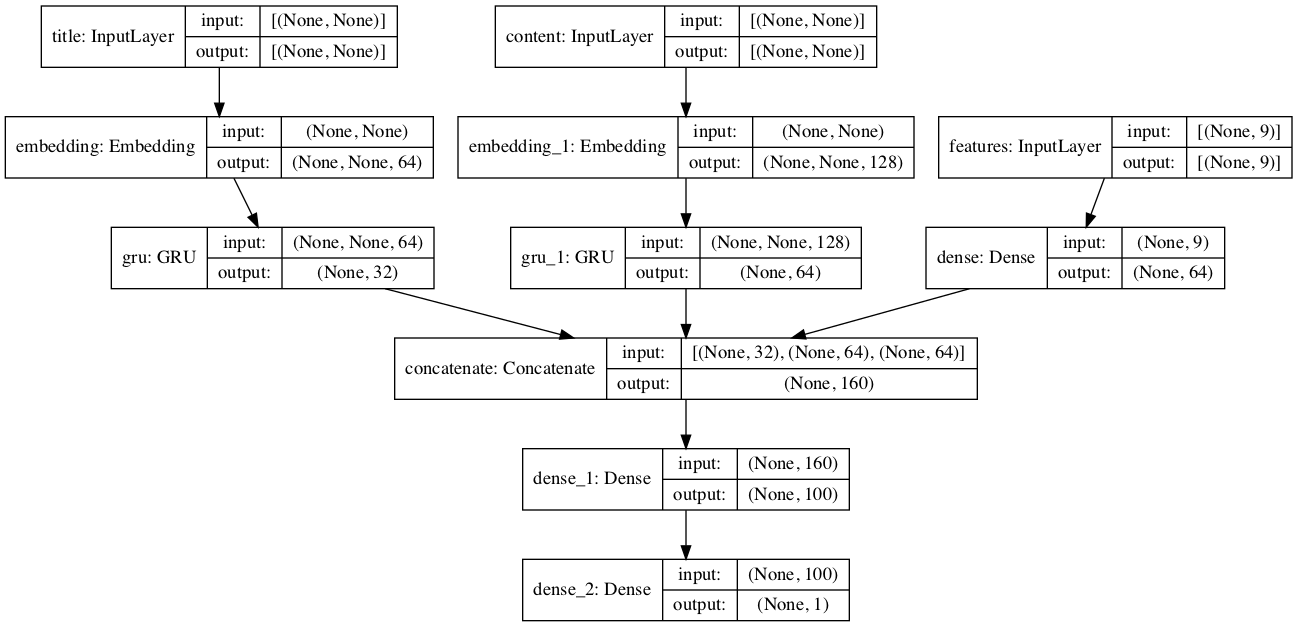

In [34]:
model = Model(inputs=[title_input, content_input, features_input], outputs=pred)
plot_model(model, "multi_input_model.png", show_shapes=True)

#### Configuración de modelo

In [35]:
model.compile(optimizer=Adam(), loss=["mae"], metrics=kmetrics)

#### Callbacks

In [36]:
early_stopping = EarlyStopping(monitor='val_mae', patience=15, min_delta=0.0001)
checkpoint = ModelCheckpoint('models/onp/model_{val_mae:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_mae')

#### Train-test split

In [37]:
Xtitle_train, Xtitle_test, Xcontent_train, Xcontent_test, Xfeatures_train, Xfeatures_test, y_train, y_test = train_test_split(X_title, X_content, X_features, y, train_size=0.7, shuffle=True)

#### Entrenamiento

In [38]:
history = model.fit(x={"title": Xtitle_train, "content": Xcontent_train, "features": Xfeatures_train}, 
                    y=y_train, 
                    epochs=100,
                    validation_data=([Xtitle_test, Xcontent_test, Xfeatures_test], y_test),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/100
3/3 [==============================] - 4s 365ms/step - loss: 0.5315 - rms: 0.5782 - mae: 0.5315 - pema: 6696972.0000 - val_loss: 0.3493 - val_rms: 0.4287 - val_mae: 0.3493 - val_pema: 527.2204
Epoch 2/100
3/3 [==============================] - 0s 87ms/step - loss: 0.2609 - rms: 0.3440 - mae: 0.2609 - pema: 3161032.7500 - val_loss: 0.1517 - val_rms: 0.2547 - val_mae: 0.1517 - val_pema: 233.6380
Epoch 3/100
3/3 [==============================] - 0s 87ms/step - loss: 0.1373 - rms: 0.2243 - mae: 0.1373 - pema: 491555.1562 - val_loss: 0.2267 - val_rms: 0.2665 - val_mae: 0.2267 - val_pema: 617.4127
Epoch 4/100
3/3 [==============================] - 0s 85ms/step - loss: 0.2142 - rms: 0.2481 - mae: 0.2142 - pema: 2527279.2500 - val_loss: 0.2230 - val_rms: 0.2643 - val_mae: 0.2230 - val_pema: 600.1375
Epoch 5/100
3/3 [==============================] - 0s 85ms/step - loss: 0.1930 - rms: 0.2342 - mae: 0.1930 - pema: 2135064.0000 - val_loss: 0.1800 - val_rms: 0.2475 - val_mae: 0.1800 -

#### Análisis de resultados

In [39]:
import cufflinks as cf
cf.go_offline()

results = pd.DataFrame(data = zip(history.history["loss"], history.history["val_loss"], history.history["pema"], history.history["val_pema"]), columns=["loss", "val_loss", "pema", "val_pema"])
results.iplot(theme="solar")

#### Predicción

In [40]:
loss, *metrics = model.evaluate([Xtitle_test, Xcontent_test, Xfeatures_test], y_test)

1/1 [==============================] - 0s 29ms/step - loss: 0.1459 - rms: 0.2554 - mae: 0.1459 - pema: 170.9048


In [41]:
loss, metrics

(0.14591509103775024,
 [0.2553984522819519, 0.14591509103775024, 170.90476989746094])

In [42]:
y_true = sc.inverse_transform(np.expand_dims(y_test, axis=1))
y_pred = sc.inverse_transform(model.predict([Xtitle_test, Xcontent_test, Xfeatures_test]))
pd.DataFrame(zip(y_true.ravel(), y_pred.ravel())).iplot(kind="histogram", histnorm="probability density", theme="solar")

In [43]:
r2_score(y_pred=y_pred, y_true=y_true)

-0.06530814449568534

## Modelado no supervisado

#### Ingeniería de datos "profunda"

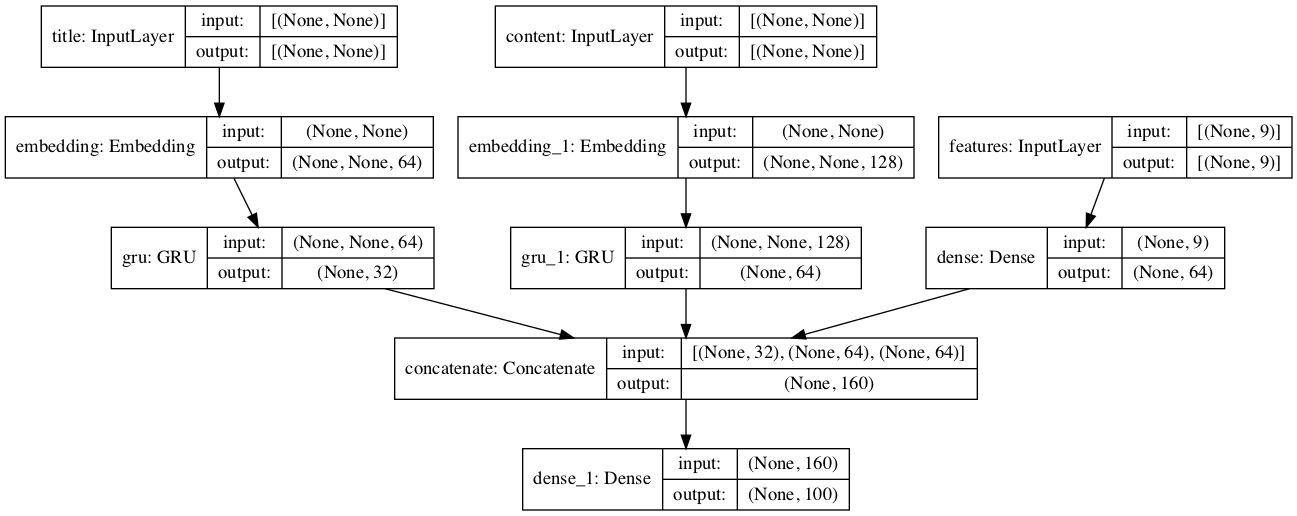

In [44]:
# Just changing the outputs to pre-last layer you'll have trained-weights so it could work as super-feature extraction!
model_transformer = Model(inputs=[title_input, content_input, features_input], outputs=x)
plot_model(model_transformer, "model_transformer.png", show_shapes=True)

In [45]:
X_input = [X_title, X_content, X_features]
Xt = model_transformer.predict(X_input)
Xt.shape

(100, 100)

In [46]:
sc_x = MinMaxScaler()
Xs = pd.DataFrame(data=sc_x.fit_transform(Xt), columns=[f"x_{i}" for i in range(Xt.shape[1])])
Xs.sample()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_90,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99
88,0.580436,0.59232,0.55992,0.5492,0.664891,0.500741,0.618881,0.659772,0.566996,0.684155,...,0.355507,0.351931,0.708499,0.493526,0.508936,0.279589,0.674476,0.83115,0.21151,0.645671


### Visualización

In [47]:
pca = PCA(n_components=0.9)
pca.fit(Xs)
pca.n_components_

8

In [48]:
pca.explained_variance_ratio_.cumsum()

array([0.35730702, 0.5232802 , 0.65878296, 0.7438217 , 0.8063557 ,
       0.8559248 , 0.89757985, 0.934535  ], dtype=float32)

In [49]:
Xp = pd.DataFrame(columns=[f"p{i+1}" for i in range(pca.n_components_)], data=pca.transform(Xs))
Xp.sample()

,p1,p2,p3,p4,p5,p6,p7,p8
69,-0.679861,0.154963,-0.275789,0.286783,0.907146,-0.205723,-0.011098,-0.539684


In [50]:
Xp.iplot(kind="scatter", x="p1", y="p2", mode="markers", theme="solar")

In [51]:
Xp.iplot(kind="scatter3d", x="p1", y="p2", z="p3", mode="markers", theme="solar")

### K-Means

In [52]:
cluster = KMeans(n_clusters=3, random_state=777)
df["cl"] = Xs["cl"] = Xp["cl"] = [str(x) for x in cluster.fit_predict(Xs)]
df["cl"].value_counts(True)

2    0.49
0    0.44
1    0.07
Name: cl, dtype: float64

### Perfilamiento

In [53]:
Xp.join(df[["title"]]).iplot(kind="scatter", x="p1", y="p2", mode="markers", categories="cl", text="title", theme="solar")

/Users/efraflores/Desktop/hub/datathon2021/venv/lib/python3.9/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/Users/efraflores/Desktop/hub/datathon2021/venv/lib/python3.9/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [54]:
Xp.join(df[["title"]]).iplot(kind="scatter3d", x="p1", y="p2", z="p3", mode="markers", categories="cl", text="title", theme="solar")

In [55]:
df.groupby("cl").mean().style.background_gradient(cmap='Blues')

,n_headers,n_images,n_videos,n_paragraphs,neg_title,neu_title,pos_title,compound_title,neg_text,neu_text,pos_text,compound_text,n_urls,len_title,n_words_title,avg_len_words_title,len_content,n_words_content,avg_len_words_content,shares
cl,,,,,,,,,,,,,,,,,,,,
0,0.409091,1.863636,1.659091,1.000000,0.031727,0.787409,0.180818,0.228900,0.037932,0.812841,0.149227,0.342555,0.477273,50.272727,8.909091,4.808133,2368.204545,376.181818,5.444431,5.619359
1,0.571429,1.571429,2.000000,1.000000,0.050286,0.910429,0.039286,-0.053029,0.045286,0.940000,0.014714,-0.154000,0.571429,55.000000,9.285714,5.061173,1851.857143,292.285714,5.496701,48.483190
2,0.163265,1.448980,1.183673,1.000000,0.112735,0.843449,0.043776,-0.102865,0.053388,0.892551,0.054082,-0.056735,0.448980,60.142857,9.693878,5.406993,2000.000000,314.693878,5.441537,9.998596
